In [16]:
# Importing Necessary Libraries
from skimage import data
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt

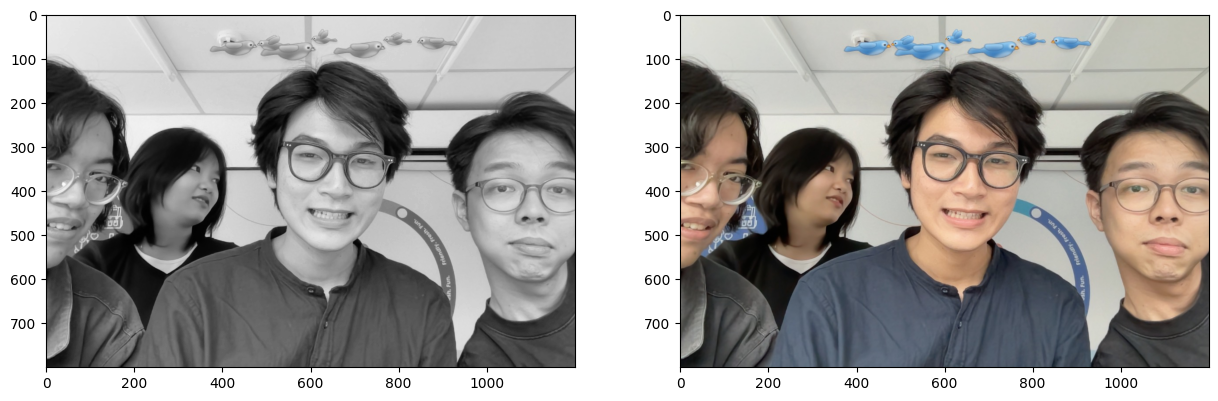

In [21]:
plt.figure(figsize=(15, 15))

# Sample Image of scikit-image package
photo = 'image/photo1.jpeg'
photo = imread(photo)
plt.subplot(1, 2, 2)

# Displaying the sample image
plt.imshow(photo)

# Converting RGB image to Monochrome
gray_photo = rgb2gray(photo)
plt.subplot(1, 2, 1)

# Displaying the sample image - Monochrome
# Format
plt.imshow(gray_photo, cmap="gray")

# Mean Shift Clustering

In [45]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

from skimage.segmentation import slic, quickshift
from skimage.color import label2rgb


In [ ]:
# Setting the plot size as 15, 15
plt.figure(figsize=(15,15))

image = 'image/photo1.jpeg'
image = imread(image)
# Applying Simple Linear Iterative
# Clustering on the image
# - 50 segments & compactness = 10
image_segments = slic(image,
                          n_segments=50,
                          compactness=50)
plt.subplot(1,2,1)

# Plotting the original image
plt.imshow(image)
plt.subplot(1,2,2)

# Converts a label image into
# an RGB color image for visualizing
# the labeled regions. 
plt.imshow(label2rgb(image_segments,
                     image,
                     kind = 'avg'))


: 

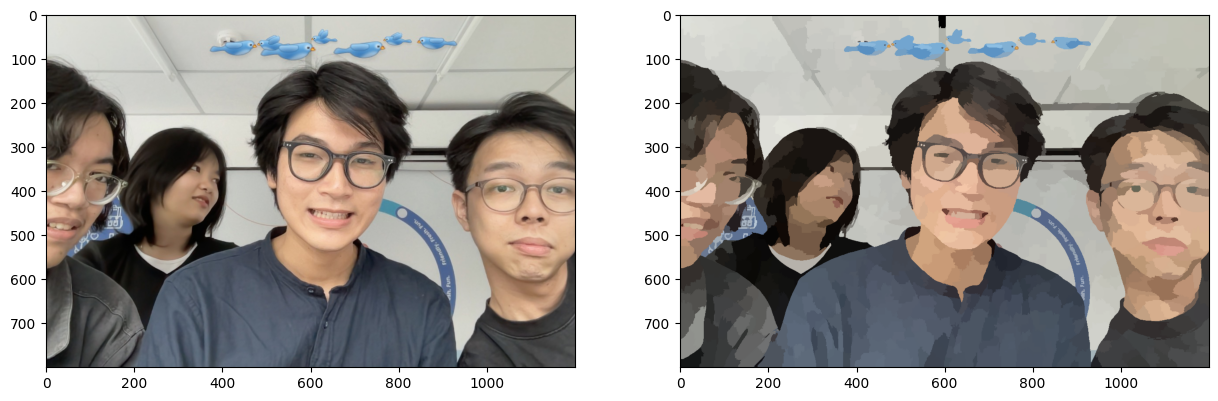

In [48]:
# Setting the plot size as 15, 15
plt.figure(figsize=(15,15))

image = 'image/photo1.jpeg'
image = imread(image)
# Applying Simple Linear Iterative
# Clustering on the image
# - 50 segments & compactness = 10
image_segments = quickshift(image,
                            kernel_size=5,
                            max_dist=10)
plt.subplot(1,2,1)

# Plotting the original image
plt.imshow(image)
plt.subplot(1,2,2)

# Converts a label image into
# an RGB color image for visualizing
# the labeled regions. 
plt.imshow(label2rgb(image_segments,
                     image,
                     kind = 'avg'))
